In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import pickle
%matplotlib inline
from pathlib import Path

from imblearn.over_sampling import SMOTE
from tqdm import tqdm
# SK-Learn related libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

C:\Users\Chern\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
os.chdir(Path().absolute())

### Data Loading  
1. Read german.data
2. Replace string 'na' to actual NA

In [3]:
# read dataset, skip first 20 rows description, replace 'na' to NA
df = pd.read_csv('german.data', sep=' ', na_values=['na'], header=None)
df.columns = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
              'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
              'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
              'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
# create a backup original dataframe
df_ori = df

### Data Exploration & Preprocessing Phase  
1. Explore dataframe summary (min, max, median, etc..)
    - 8 features variables are numeric
2. Check target class for missing values :  
    - There is no missing value in target class.
    - Transform target class to binary (Label Encoding)
3. Check predictors for missing values :  
    - There is 0 features with missing values
4. Transform categorial predictors 
    - 
5. Explore pairwise relationship between predictors

In [4]:
# 1. Dataframe summary
print('Total columns = {}'.format(df.shape[1]))
print('Total numeric columns = {}'.format(df.select_dtypes(include='number').shape[1]))
df.describe()

Total columns = 21
Total numeric columns = 8


,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,classification
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


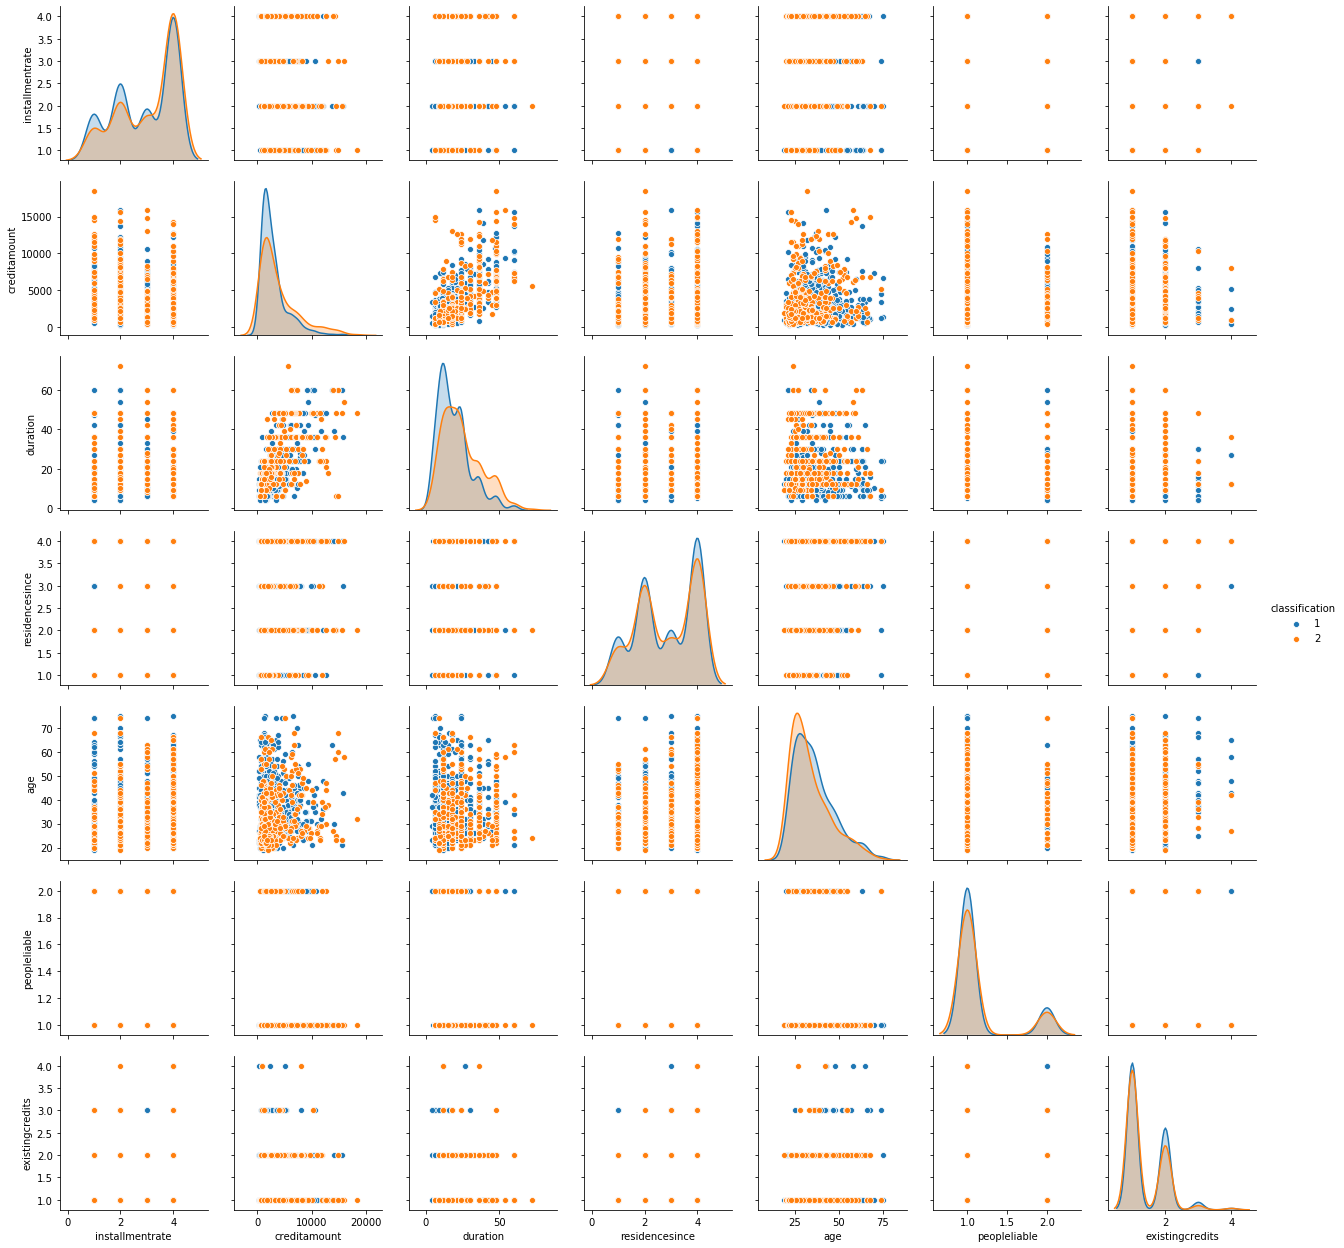

In [5]:
tmp_var = df.select_dtypes(include='number').columns.values
sns.pairplot(df.loc[:, ], hue = 'classification', 
             vars=list(set(tmp_var) - set(['classification'])) )
# tmp_var = df.select_dtypes(exclude='number').columns.values
# tmp_var = np.append(tmp_var, 'classification')

target class, missing : 0
target distribution : [1 2], [700 300]


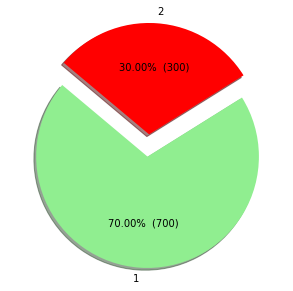

In [6]:
# 2. Target variable exploration
target_var = df['classification'].value_counts()

# Data to plot
labels = target_var.index
values = target_var.values
colors = ['lightgreen', 'red']
explode = [0 if i=='2' else 0.1 for i in target_var.index]

# Create value & percentage label
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

# Transform target variable to binary
df['classification'] = LabelEncoder().fit_transform(df['classification'].values)


missing_target = df['classification'].isna().sum()
print('target class, missing : {}'.format(missing_target))
print('target distribution : {0}, {1}'.format(labels.values, values))

# Plot
rcParams['figure.figsize'] = 5, 5
plt.pie(values, labels = labels, explode = explode,
        colors = colors, autopct = make_autopct(values), shadow = True, startangle = 140)
plt.axis('equal')
plt.show()

In [7]:
# 3A. Feature variables exploration
missing_predictor = (df.loc[:,df.columns != 'classification'].isnull().sum() /  \
                        df.loc[:,df.columns != 'classification'].shape[0]).sort_values(ascending=False)

# No missing values found
print('Predictors with missing value : {}'.format(len(missing_predictor[missing_predictor.values > 0.])))

Predictors with missing value : 0


In [8]:
# 3B. Data Preprocessing
# Standardize numerical variable 
num_data = df.select_dtypes(include='number')
scaler = StandardScaler().fit(num_data)
num_data = scaler.transform(num_data)
num_data = pd.DataFrame(num_data, columns = df.select_dtypes(include='number').columns)

# Transform categorial variable, encode to integer
cat_data = df.select_dtypes(exclude='number')
cat_data = pd.get_dummies(cat_data)

df_trans_scaled = pd.concat([num_data, cat_data], axis = 1)
df_trans_scaled.drop(columns='classification', axis=1, inplace=True)
df_trans_scaled = pd.concat([df_trans_scaled, df.classification], axis = 1)

df_trans = pd.concat([df.select_dtypes(include='number'), cat_data], axis = 1)

In [9]:
# 3C. Finding important features
X, y = df_trans_scaled.loc[:, np.delete(df_trans_scaled.columns.values, 
                                        np.where(df_trans_scaled.columns.values == ['classification']))], \
        df_trans_scaled.loc[:, 'classification']

# train on randomForest to get important features
clf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
clf.fit(X, y) 

feature_importances = pd.DataFrame(sorted(zip(df_trans_scaled.columns, clf.feature_importances_), key=lambda x: x[1] * -1),
                                    columns = ['feature','importance'])

### Model Development
1. Train Model with selected important features
    - Logistic Classifier
    - RandomForest Classifier
2. Hypertune model parameters and identify best parameters for challenge metrics.
3. Select best model that achieve best challenge metrics

In [10]:
# Select non zero importance features
top_features = feature_importances[feature_importances.importance>0]['feature'].values

X, y = df_trans_scaled.loc[:,top_features], df_trans_scaled.loc[:,'classification']

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Apply SMOTE to address imbalance class issue
sm = SMOTE(random_state=0)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [11]:
# define function to calculate challenge metric 
def cal_metric(y_actual,y_pred):
    """
     True class      |   Predicted class     |
                     |    1      |    2      |
     -----------------------------------------
      1              |     -     |  Cost_1   |
     -----------------------------------------
      2              |  Cost_2   |     -     |
     -----------------------------------------
     Cost_1 = 1 and cost_2 = 5

     Total_cost = Cost_1*No_Instances + Cost_2*No_Instances.
    """
    cost_1 = 1
    cost_2 = 5
    tn, fp, fn, tp = confusion_matrix(y_true=y_actual, y_pred=y_pred).ravel()
    return (cost_2 * fp) + (cost_1 * fn)

In [12]:
# Create dataframe to store classifiers results
train_test_result = pd.DataFrame(columns = ['Best Estimator', 'Best Params', 'Best Score', 'Test ROC', 
                                            'Test Accuracy', 'Test Challenge Metric'])

In [13]:
# # params = {'n_estimators': [100, 200, 300, 500],
# #           'max_depth' : [1, 3, 5, 7, 9],
# #           'min_samples_split' : [2, 3, 5, 7],
# #           'min_samples_leaf' : [2, 3, 5, 7],
# #           'random_state' : [1]
# #          }
# params = {'n_estimators': [200, 300],
#   'max_depth' : [3, 5],
#   'min_samples_split' : [2, 3],
#   'min_samples_leaf' : [2, 3],
#   'random_state' : [1] }
          
# helper_clf = GridSearchCV(RandomForestClassifier(), params, scoring = 'roc_auc',
#                           cv = 5, verbose = 10, n_jobs = 6, return_train_score = True)
# helper_clf.fit(X_train, y_train)
helper_clf = pickle.load(open('rf_credit_clf.pkl', 'rb'))
y_pred = helper_clf.predict(X_test)

roc_score = metrics.roc_auc_score(y_test, y_pred)
acu_score = metrics.accuracy_score(y_test, y_pred)
chal_score = cal_metric(y_test, y_pred)

train_test_result = train_test_result.append(pd.DataFrame([(helper_clf.best_estimator_, helper_clf.best_params_, 
                                        helper_clf.best_score_, roc_score, acu_score, chal_score)],                                      
                                        columns = ['Best Estimator', 'Best Params', 'Best Score', 'Test ROC', 
                                                   'Test Accuracy','Test Challenge Metric']))

print('Test ROC : {}, Test Accuracy : {}, Test Challenge Metric : {}'.format(roc_score, acu_score, chal_score))
# pickle.dump(helper_clf, open('rf_credit_clf.pkl', 'wb'))

Test ROC : 0.7442933462846042, Test Accuracy : 0.76, Test Challenge Metric : 172


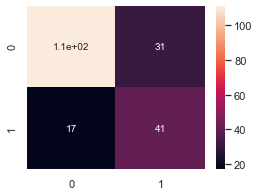

In [14]:
sns.set(rc={'figure.figsize':(4,3)})
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,annot_kws={"size": 10})

In [15]:
# params = {'C': np.linspace(1,10,10) ,
#           'penalty': ['l1', 'l2'], 
#           'solver' : ['liblinear'],
#           'random_state' : [1] }
          
# helper_clf = GridSearchCV(LogisticRegression(), params, scoring = 'roc_auc',
#                           cv = 5, verbose = 10, n_jobs = 6, return_train_score = True)
# helper_clf.fit(X_train, y_train)
helper_clf = pickle.load(open('logit_credit_clf.pkl', 'rb'))
y_pred = helper_clf.predict(X_test)

roc_score = metrics.roc_auc_score(y_test, y_pred)
acu_score = metrics.accuracy_score(y_test, y_pred)
chal_score = cal_metric(y_test, y_pred)

train_test_result = train_test_result.append(pd.DataFrame([(helper_clf.best_estimator_, helper_clf.best_params_, 
                                        helper_clf.best_score_, roc_score, acu_score, chal_score)],                                      
                                        columns = ['Best Estimator', 'Best Params', 'Best Score', 'Test ROC', 
                                                   'Test Accuracy','Test Challenge Metric']))

print('Test ROC : {}, Test Accuracy : {}, Test Challenge Metric : {}'.format(roc_score, acu_score, chal_score))
# pickle.dump(helper_clf, open('logit_credit_clf.pkl', 'wb'))

Test ROC : 0.6761777561923263, Test Accuracy : 0.685, Test Challenge Metric : 235


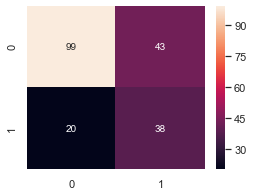

In [16]:
sns.set(rc={'figure.figsize':(4,3)})
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,annot_kws={"size": 10})

In [17]:
# Best Trained Estimator & Results
train_test_result

,Best Estimator,Best Params,Best Score,Test ROC,Test Accuracy,Test Challenge Metric
0,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 5, 'min_samples_leaf': 2, 'min_s...",0.902051,0.744293,0.760,172
0,"LogisticRegression(C=1.0, class_weight=None, d...","{'C': 1.0, 'penalty': 'l2', 'random_state': 1,...",0.833149,0.676178,0.685,235


## Comparing LogisticRegrssion & RandomForest Classifier model
1. RandomForest achieve better result in terms of AUC & Cost Metrics. As shown below.

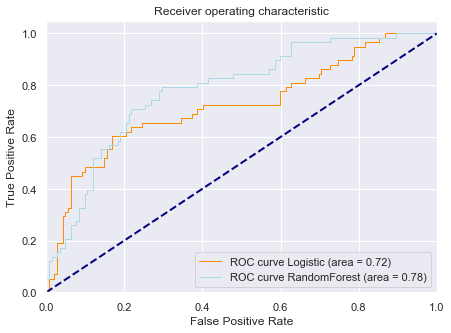

In [18]:
fpr, tpr, thresholds  = metrics.roc_curve(y_test, pickle.load(open('logit_credit_clf.pkl', 'rb')).predict_proba(X_test)[:,1] )
roc_auc = metrics.auc(fpr, tpr)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test, pickle.load(open('rf_credit_clf.pkl', 'rb')).predict_proba(X_test)[:,1] )
roc_auc2 = metrics.auc(fpr2, tpr2)

sns.set(rc={'figure.figsize':(7,5)})
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve Logistic (area = %0.2f)' % roc_auc)
plt.plot(fpr2, tpr2, color='lightblue', lw=1, label='ROC curve RandomForest (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()